In [20]:
import requests
import matplotlib
import pandas as pd

league_id = 761347
year = 2023

url = "https://fantasy.espn.com/apis/v3/games/ffl/seasons/"+ str(year)+"/segments/0/leagues/" +str(league_id)

r = requests.get(url)

In [27]:
matchups_r = requests.get(url, 
                 params={"view": "mMatchup"})
matchups = matchups_r.json()

teams_r = requests.get(url, 
                 params={"view": "mTeams"})
teams = teams_r.json()

In [28]:
matchups_df = [[
        game['matchupPeriodId'],
        game['home']['teamId'], game['home']['totalPoints'],
        game['away']['teamId'], game['away']['totalPoints']
    ] for game in matchups['schedule']]
matchups_df = pd.DataFrame(matchups_df, columns=['Week', 'Team1', 'Score1', 'Team2', 'Score2'])

In [29]:
teams_df = [[
        team['id'],
        team['abbrev']
    ] for team in teams['teams']]
teams_df = pd.DataFrame(teams_df, columns=['TeamId', 'TeamName'])

In [30]:
output = matchups_df.merge(
    teams_df, 
    left_on='Team1', 
    right_on='TeamId'
).rename(columns={"TeamName": "TeamName1", "TeamId": "TeamId1"}
).merge(
        teams_df,
        left_on = 'Team2',
        right_on = 'TeamId'
).rename(columns={"TeamName": "TeamName2", "TeamId": "TeamId2"})

teamScores = pd.concat( [
    output[['Week', 'TeamName1', 'Score1']].rename(columns={'Week':'Week', 'TeamName1': 'TeamName','Score1': 'Score'}),
    output[['Week', 'TeamName2', 'Score2']].rename(columns={'Week':'Week', 'TeamName2': 'TeamName','Score2': 'Score'}),
]
).sort_values(by=['TeamName','Week'])

# output[(output['TeamName1']=='Cobra Kyler') | (output['TeamName2']=='Cobra Kyler')].sort_values(by=['Week'])

In [31]:
teamScores['moving'] = teamScores.groupby('TeamName')['Score'].transform(lambda x: x.rolling(3, 1).mean())

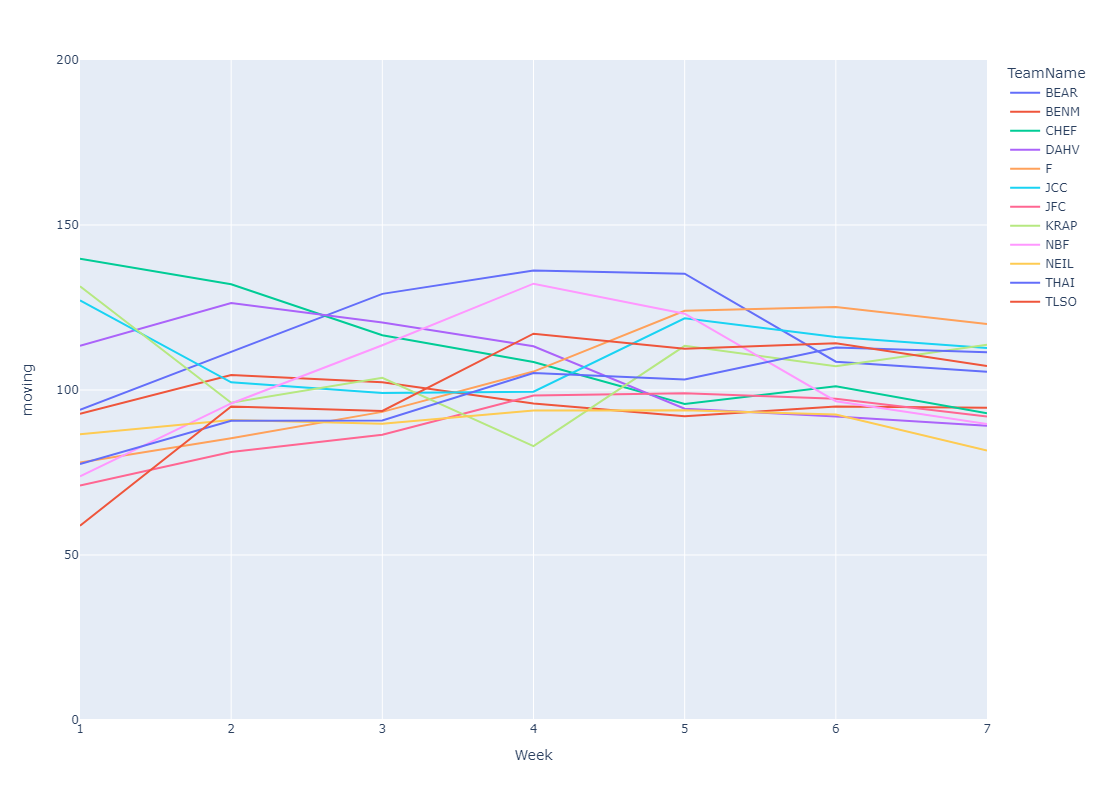

In [32]:
import plotly.express as px

currentTeamScores = teamScores[(teamScores['Week']<=7)]

fig = px.line(currentTeamScores, x="Week", y="moving", color='TeamName', height = 800)
fig.update(layout_yaxis_range  = [0,200])
fig.show()